# Quantum Model on different dataset

In [1]:
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import  Options
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_provider import IBMProvider
from qiskit.quantum_info import Operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torchmetrics import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError

from typing import Optional, Union
from tqdm import tqdm


sns.set_theme()
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)




/var/folders/dp/ld4glq1d11s75ygqlpsxj8jm0000gn/T/ipykernel_44485/1249841839.py:11: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


## Load data (sinus wave)

In [55]:
FIRST = 1850
LAST = 2021  # inclusive
LAST_TRAIN =2005
LAST_VALID =2018
LAST_TEST = 2021

# Reference period for the center of the color scale

FIRST_REFERENCE = 1971
LAST_REFERENCE = 2000
LIM = 0.7 # degrees

df = pd.read_fwf(
    '12_Global_Warming_data.txt',
    index_col=0,
    usecols=(0, 1),
    names=['year', 'anomaly'],
    header=None,
)

data = df.loc[FIRST:LAST, 'anomaly'].dropna()
reference = data.loc[FIRST_REFERENCE:LAST_REFERENCE].mean()

cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

train_df = df.loc[FIRST:LAST_TRAIN, 'anomaly'].dropna().reset_index().set_index("year")
valid_df = df.loc[LAST_TRAIN+1:LAST_VALID, 'anomaly'].dropna().reset_index().set_index("year")
test_df = df.loc[LAST_VALID+1:LAST_TEST, 'anomaly'].dropna().reset_index().set_index("year")

train_df = pd.concat([train_df,train_df['anomaly'].shift(periods=[2,5])],axis=1)
valid_df = pd.concat([valid_df,valid_df['anomaly'].shift(periods=[2,5])],axis=1)
test_df = pd.concat([test_df,test_df['anomaly'].shift(periods=[2,5])],axis=1)

train_scaler_amount=MinMaxScaler()
train_scaler_account=MinMaxScaler()
train_df=train_scaler_amount.fit_transform(train_df[['anomaly','anomaly_2','anomaly_5']])[5:,:]
# train_df=np.diff(history_train,axis=0)[5:,:]

#Validation data dont need a separate scaler. 
valid_df=train_scaler_amount.transform(valid_df[['anomaly','anomaly_2','anomaly_5']])[5:,:]
# valid_df=np.diff(history_valid,axis=0)[5:,:]

test_df=train_scaler_amount.transform(test_df[['anomaly','anomaly_2','anomaly_5']])[5:,:]
# test_df=np.diff(history_test,axis=0)[5:,:]


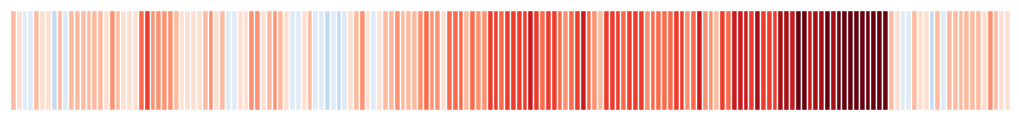

In [64]:
fig = plt.figure(figsize=(10, 1))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(FIRST, LAST + 1)
])

# set data, colormap and color limits

col.set_array(train_df[:,0])
col.set_cmap(cmap)
col.set_clim(reference - LIM, reference + LIM)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(FIRST, LAST + 1)

# plt.figure(figsize=(15,5))
# plt.plot(np.arange(len(train_df[:,0])),train_df[:,0], color='blue', label='Train data')
plt.show()

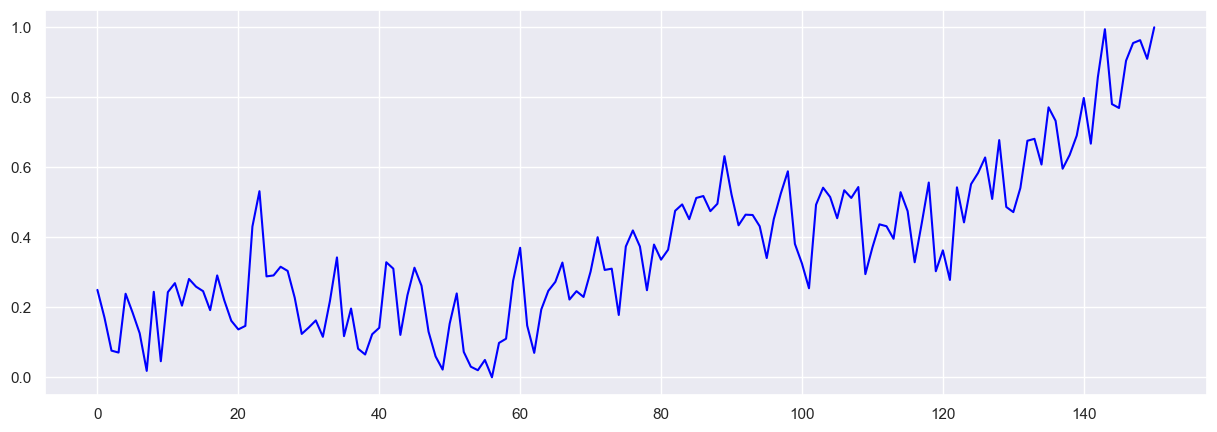

In [66]:
plt.figure(figsize=(15,5))
plt.plot(train_df[:,0], color='blue', label='Train data')

In [67]:
######## TIme Window #######
def time_window(input_data, window):
    window_data = []
    L = len(input_data)
    for i in range(L-window):
        train_series = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1,0]
        # train_label = input_data[i+1:i+window+1,0]
        window_data.append((train_series ,train_label))
    return window_data

def time_window_batch(input_data, window, batch_size):
    window_data = []
    L = len(input_data)
    for i in range(0, L - window, batch_size):
        train_series_batch = []
        train_label_batch = []
        for j in range(batch_size):
            train_series = input_data[i+j:i+j+window]
            train_label = input_data[i+j+window:i+j+window+1, 0]
            train_series_batch.append(train_series)
            train_label_batch.append(train_label)
        window_data.append((np.array(train_series_batch), np.array(train_label_batch)))
    return window_data


In [68]:
def create_pauli_ops(q):
    if not isinstance(q, int) or q <= 0:
        raise ValueError("q must be a positive integer")
    
    pauli_ops = []
    for i in range(q):
        pauli_str = "I" * i + "Z" + "I" * (q - i - 1)
        pauli_op = SparsePauliOp.from_list([(pauli_str,1)])
        pauli_ops.append(pauli_op)
    
    return pauli_ops

In [69]:

class QLongShortTermMemory(nn.Module):
    def __init__(self,
                 input_size: int,
                 num_hiddens: int,
                 batch_size: int,
                 backend,
                 n_layers: Optional[int] = 1, #of the Entanglement layer = reps
                 n_qubits: Optional[int] = 1,
                 feature_map: QuantumCircuit = None,
                 ansatz: QuantumCircuit = None,
                 cx_layer: bin=False,
                 xyz_order: str = None,
                 xyz_factor: str= None,
                 activation: torch.functional= None,
                 clamp=False,
                 ):
        super(QLongShortTermMemory, self).__init__()
        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.batch_size=batch_size
        self.backend=backend
        self.n_layers = n_layers
        self._qlayers = {}
        self.activation=activation
        self.clamp=clamp

        ####### Feature Map #######
        qc_encoding = QuantumCircuit(n_qubits)
        for i in range(n_qubits):
            qc_encoding.h(i)

        thet= ParameterVector('x',n_qubits)
        for i in range(n_qubits):
            if cx_layer:
                 if i==0:
                    qc_encoding.cx(i,i+1)
                    qc_encoding.cx(i+1,i+2)                   
            if xyz_order:
                for j in range(len(xyz_order)):
                    el=xyz_order[j]
                    fa=xyz_factor[j]
                    fact={
                        '1':thet[i],
                        '2': np.square(thet[i]),
                        '3': np.square(thet[i])*thet[i]
                    }
                    if el=='x':
                        qc_encoding.rx(np.arcsin(fact[fa]),i)
                    if el=='y':
                        qc_encoding.ry(np.arcsin(fact[fa]),i)
                    if el=='z':
                        qc_encoding.rz(np.arcsin(fact[fa]),i)
                                                                      


        # two_x = TwoLocal(n_qubits, 'ry', reps=0, parameter_prefix='x', insert_barriers=True, name='Encoding Block - ry arctanx')
        # two_x2 = TwoLocal(n_qubits, 'rz', reps=0, parameter_prefix='x2', insert_barriers=True, name='Encoding Block - rz arctanx2')
        # feature_map=qc_encoding.compose(two_x).compose(two_x2)
        feature_map=qc_encoding

        ####### Vartiational Part - Entanglement######
        layer_1 = []
        for i in range(n_qubits-1):
            pairs = (i, i+1)
            layer_1.append(pairs)
        layer_2 = [(n_qubits-1, 0)]
        layer_3 = []
        for i in range(n_qubits-2):
            pairs = (i, i+2)
            layer_3.append(pairs)
        layer_4 = []
        for i in range(n_qubits-2):
            pairs = (i+2, i)
            layer_4.append(pairs)
        
       
        qc_var_cx_paper = TwoLocal(n_qubits, [], 'cx', [layer_1, layer_2,layer_3,layer_4], reps=4, parameter_prefix='x', name='Variational Block - cx')
        qc_var_cx = TwoLocal(3, [], 'cx', [layer_1, layer_2], reps=2, parameter_prefix='x', insert_barriers=True, name='Variational Block - cx')

        #qc_var_cx = TwoLocal(3, [], 'cx', [layer_4, layer_1_2], reps=2, parameter_prefix='x', insert_barriers=True, name='Variational Block - cx')

        ####### Variational Part - Rotations #########
        qc_var_rot = TwoLocal(3, ['ry'],reps=0, name = 'Variational Block - ri') #Ansatz 999
        
        ansatz= qc_var_rot
        if ansatz:
            ansatz=ansatz
        else:
            ansatz= qc_var_cx.compose(qc_var_rot)

        # quantum layers
        self._construct_quantum_layers(feature_map, ansatz)

        # classical layers
        self.clayer_in = nn.Linear(input_size + num_hiddens, n_qubits,bias=False)
        self.clayer_out = nn.Linear(n_qubits, num_hiddens,bias=False)

    def _construct_quantum_layers(self, feature_map, ansatz):
        for layer_name in ['forget', 'input', 'update', 'output']:
            # define the layer using EstimatorQNN from qiskit ml
            n_inputs = feature_map.num_qubits
            qc = QuantumCircuit(n_inputs)
            qc.append(feature_map, range(n_inputs))
            qc.append(ansatz, range(n_inputs))

            input_params = list(feature_map.parameters)
            weight_params = list(ansatz.parameters)

            obs = create_pauli_ops(n_inputs)
             # Noise model 
            noisy_estimator = AerEstimator(
                            backend_options={
                                "method": "density_matrix",
                                "coupling_map": self.backend['coupling'],
                                "noise_model": self.backend['noise'],
                            },
                            run_options={
                                "seed": self.backend['seed'], 
                                "shots": self.backend['shots'], 
                                "resilience_level":self.backend['res_level'] },
                            transpile_options={"seed_transpiler": self.backend['seed']},
                        )
            layer = EstimatorQNN(
                            estimator=noisy_estimator,
                            circuit=qc,
                            input_params=input_params,
                            weight_params=weight_params,
                            #exp_val=AerPauliExpectation(),
                            input_gradients=True,
                            observables=obs,
                            #observables=[obs1,obs2,obs3,obs4,obs5,obs6,obs7,obs8,obs9,obs10]
                            )
            # parity= lambda x: "{:b}".format(x).count("1") % 2
            # layer = SamplerQNN(circuit=qc,
            #                 input_params=feature_map.parameters,
            #                 weight_params=ansatz.parameters,
            #                 #exp_val=AerPauliExpectation(),
            #                 interpret=parity,
            #                 output_shape=n_inputs,
            #                 input_gradients=True
            #                 )
            initial_weights = Tensor(np.random.normal(0,0.01,len(weight_params)))

            self._qlayers[layer_name] = TorchConnector(layer, initial_weights=initial_weights)

    def forward(self,
                x: Tensor,
                H_C: Optional[Tensor] = None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros(self.batch_size, self.num_hiddens)
            C = torch.zeros(self.batch_size, self.num_hiddens)
        else:
            H, C = H_C.detach()
        outputs = []
        for X in x:      
            X=X.reshape((x.shape[1],x.shape[2]))
            V_t = torch.cat((H, X), dim=1)
            if self.activation:
                x_in = self.activation(self.clayer_in(V_t))
            elif self.clamp:
                x_in = torch.clamp(self.clayer_in(V_t),min=-0.99,max=0.99)
            else:
                x_in = self.clayer_in(V_t)
            I = torch.sigmoid(self.clayer_out(self._qlayers['input'](x_in)))
            F = torch.sigmoid(self.clayer_out(self._qlayers['forget'](x_in)))
            O = torch.sigmoid(self.clayer_out(self._qlayers['output'](x_in)))
            C_tilde = torch.tanh(self.clayer_out(self._qlayers['update'](x_in)))
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H.unsqueeze(0))
         # update output
        outputs = torch.cat(outputs, dim=0)
        #outputs = outputs.transpose(0, 1).contiguous()
        return outputs, (H, C)

In [70]:
length=5
test_df_new=np.diff(test_df,axis=0)
train_window=time_window(train_df,length)
valid_window=time_window(valid_df,length)

test_window=time_window(test_df_new,length)

In [71]:
train_window=time_window_batch(train_df,length,  1)
valid_window=time_window_batch(valid_df,length, 1)

test_window=time_window_batch(test_df_new,length, 1)

In [72]:
class QModel(nn.Module):

    def __init__(self, 
                    input_dim,
                    hidden_dim, 
                    batch_size, 
                    target_size, 
                    n_qubits=0, 
                    backend='default.qubit',
                    cx_layer: bin=False,
                    xyz_order: str = None,
                    xyz_factor: str= None,
                    ansatz=None,
                    activation=None,
                    clamp=False,

                 ):
        super(QModel, self).__init__()

        seed = 71
        np.random.seed = seed
        torch.manual_seed=seed
        
        self.lstm = QLongShortTermMemory(input_dim, hidden_dim, batch_size,backend=backend, n_qubits=n_qubits,cx_layer=cx_layer,xyz_factor=xyz_factor, xyz_order=xyz_order,ansatz=ansatz,activation=activation,clamp=clamp)
        # The linear layer that maps from hidden state space to target space
        self.dense = nn.Linear(hidden_dim, target_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        dense_out = self.dense(lstm_out)
        out_scores=dense_out
        # out_scores = F.log_softmax(dense_out, dim=1)
        return out_scores

In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
 
service.backends()

[<IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_mps')>]

In [26]:
# Build noise model from backend properties

# provider = IBMProvider.save_account(token="faadf0aa7eca321e754fafb9fe87865a80f1c35b6f8281577f2ee47faeb8c6525ad26051676f1ea14e79e5cbee06566dd620cfaacca056470a6b3e19438febe1")
provider = IBMProvider()
service_qiskit = QiskitRuntimeService.save_account(overwrite=True,channel="ibm_quantum", token="faadf0aa7eca321e754fafb9fe87865a80f1c35b6f8281577f2ee47faeb8c6525ad26051676f1ea14e79e5cbee06566dd620cfaacca056470a6b3e19438febe1",name="open")
service = QiskitRuntimeService(name="open")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=6)
noise_model = NoiseModel.from_backend(backend)

In [25]:
print(noise_model)

NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['measure', 'id', 'sx', 'ecr', 'x', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [73]:
###############################
# Change manually this params
###############################
input_size = 3
hidden_dim = 4
n_qubits = 3
n_epochs = 10
target_size = 1
batch_size= 1

print(f"Input dim:    {input_size}")
print(f"LSTM output size: {hidden_dim}")
print(f"Number of qubits: {n_qubits}")
print(f"Training epochs:  {n_epochs}")


# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
backend=Aer.get_backend('qasm_simulator')


options = Options()
options.execution.shots = 10
shots = 100
hh= True
while hh:

    model = QModel(input_size,
                    hidden_dim,
                    batch_size,
                    target_size=target_size,
                    n_qubits=n_qubits,
                    backend={
                        'backend':backend, 
                        'coupling':coupling_map,
                        'noise':noise_model,
                        'seed': 71, 
                        'shots': shots,
                        'res_level': 0}, 
                    cx_layer=False,
                    xyz_order='yz',
                    xyz_factor='12',
                    ansatz=None,
                activation=None
                    )
    loss_function = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=0.01, momentum=0.2)



    model.lstm.clayer_in.requires_grad_(False)
    model.lstm.clayer_out.requires_grad_(False)

    history = {
        'train_loss': [],
        'valid_loss': [],
        'mae': [],
        'mse': []
    }

    for epoch in range(n_epochs):
        train_losses = []
        preds = []
        targets = []
        model.train()
        
        for i,X in enumerate(tqdm(train_window)):

            if i ==len(train_window)-1:
                break;
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            # Step 3. Run our forward pass.
            X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
            out_scores = model(X_in)[-1]
        # out_scores = model(X_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            # label= torch.Tensor([X[1]]).reshape((length,1))
            label= torch.Tensor([X[1]]).reshape((batch_size,1))
            loss = loss_function(out_scores,label)
            loss.backward()
            optimizer.step()
            train_losses.append(float(loss))

            # probs = torch.softmax(out_scores, dim=-1)
            # preds.append(probs.argmax(dim=-1))
            preds.append(torch.Tensor(out_scores.detach()))
            # targets.append(label[-1])
            targets.append(label)
            
        valid_losses = []
        model.eval()     
        for i,X in enumerate(tqdm(valid_window)):
            if i ==len(valid_window)-1:
                break;
            X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
            try:
                out_scores = model(X_in)[-1]
            except Exception as e:
                print("There was a mistake in the qiskit code: ",e) 
                continue     
            label= torch.Tensor([X[1]]).reshape((batch_size,1))
            loss = loss_function(out_scores,label)
            valid_losses.append(float(loss))

        avg_loss_train = np.mean(train_losses)
        avg_loss_valid = np.mean(valid_losses)
        history['train_loss'].append(avg_loss_train)
        history['valid_loss'].append(avg_loss_valid)
        # print("preds", preds,targets)
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        mean_abs_error = MeanAbsoluteError()
        mae=mean_abs_error(preds, targets)
        mean_sqrt_error = MeanSquaredError()
        mse=mean_sqrt_error(preds, targets)
        history['mae'].append(mae)
        history['mse'].append(mse)
        
        if mae > 0.15:
            hh =True
            break;
        else: 
            hh=False
        print(f"Epoch {epoch + 1} / {n_epochs}: Loss = {avg_loss_train:.3f} Valid Loss: {avg_loss_valid:.3f} MAE = {mae:.4f} MSE = {mse:.4f}")


/var/folders/dp/ld4glq1d11s75ygqlpsxj8jm0000gn/T/ipykernel_44485/2390035908.py:92: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  self._construct_quantum_layers(feature_map, ansatz)
/opt/anaconda3/envs/quantum_warming/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


Input dim:    3
LSTM output size: 4
Number of qubits: 3
Training epochs:  10


  0%|          | 0/146 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:14<00:07,  7.28s/it]


Epoch 1 / 10: Loss = 0.021 Valid Loss: 0.110 MAE = 0.1116 MSE = 0.0209


 67%|██████▋   | 2/3 [00:14<00:07,  7.26s/it]


Epoch 2 / 10: Loss = 0.025 Valid Loss: 0.119 MAE = 0.1222 MSE = 0.0246


 67%|██████▋   | 2/3 [00:14<00:07,  7.21s/it]


Epoch 3 / 10: Loss = 0.023 Valid Loss: 0.117 MAE = 0.1205 MSE = 0.0234


 67%|██████▋   | 2/3 [00:14<00:07,  7.21s/it]


Epoch 4 / 10: Loss = 0.022 Valid Loss: 0.112 MAE = 0.1180 MSE = 0.0222


 67%|██████▋   | 2/3 [00:14<00:07,  7.13s/it]


Epoch 5 / 10: Loss = 0.021 Valid Loss: 0.108 MAE = 0.1159 MSE = 0.0213


 67%|██████▋   | 2/3 [00:14<00:07,  7.22s/it]


Epoch 6 / 10: Loss = 0.021 Valid Loss: 0.104 MAE = 0.1143 MSE = 0.0207


 67%|██████▋   | 2/3 [00:14<00:07,  7.33s/it]


Epoch 7 / 10: Loss = 0.020 Valid Loss: 0.101 MAE = 0.1130 MSE = 0.0202


 67%|██████▋   | 2/3 [00:14<00:07,  7.35s/it]


Epoch 8 / 10: Loss = 0.020 Valid Loss: 0.098 MAE = 0.1119 MSE = 0.0199


 67%|██████▋   | 2/3 [00:14<00:07,  7.15s/it]


Epoch 9 / 10: Loss = 0.020 Valid Loss: 0.096 MAE = 0.1111 MSE = 0.0196


 67%|██████▋   | 2/3 [00:14<00:07,  7.17s/it]

Epoch 10 / 10: Loss = 0.019 Valid Loss: 0.094 MAE = 0.1106 MSE = 0.0195


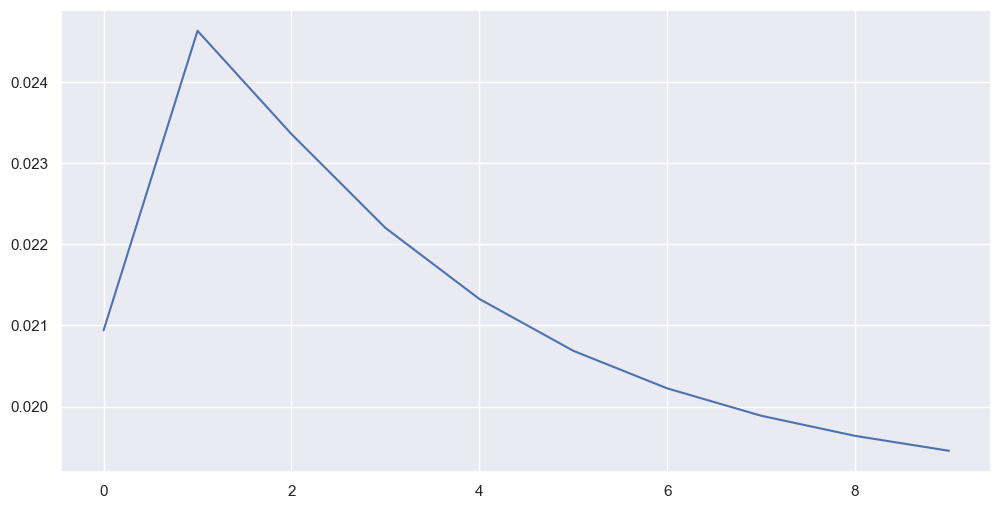

In [75]:
plt.plot(history['train_loss'])
#plt.plot(history['valid_loss'])

In [76]:
train_predictions=np.array([])
model.eval()
for i,y in enumerate(train_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        train_predictions=np.append(train_predictions,pred.detach().numpy())
    except: 
        pred=1
        train_predictions=np.append(train_predictions,pred)
    

In [77]:
predictions=np.array([])
test_labels=np.array([])
for i,y in enumerate(test_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        predictions=np.append(predictions,pred.detach().numpy())
        test_labels= np.append(test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        predictions=np.append(predictions,pred)
        test_labels= np.append(test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
t_predictions=torch.from_numpy(predictions)
t_test_labels=torch.from_numpy(test_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(t_predictions, t_test_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(t_predictions, t_test_labels)
print("MAE Test",mae)
print("MSE Test",mse)

MAE Test tensor(nan)
MSE Test tensor(nan)


In [78]:
valid_labels=np.array([])
valid_predictions=np.array([])
for i,y in enumerate(valid_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        valid_predictions=np.append(valid_predictions,pred.detach().numpy())
        valid_labels= np.append(valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        valid_predictions=np.append(valid_predictions,pred)    
        valid_labels= np.append(valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
        
t_predictions=torch.from_numpy(valid_predictions)
t_valid_labels=torch.from_numpy(valid_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(t_predictions, t_valid_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(t_predictions, t_valid_labels)
print("MAE Valid",mae)
print("MSE Valid",mse)

MAE Valid tensor(0.2558)
MSE Valid tensor(0.0709)


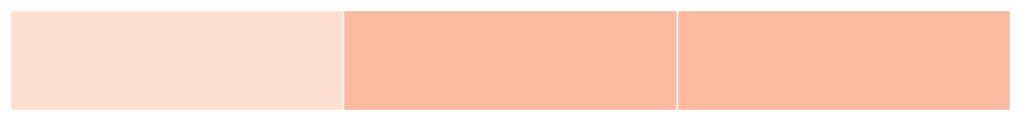

In [79]:
fig = plt.figure(figsize=(10, 1))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(+1, LAST + 1)
])

# set data, colormap and color limits

col.set_array(train_df.reshape(-1))
col.set_cmap(cmap)
col.set_clim(reference - LIM, reference + LIM)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(LAST_VALID+1, LAST + 1)

# plt.figure(figsize=(15,5))
# plt.plot(np.arange(len(train_df[:,0])),train_df[:,0], color='blue', label='Train data')
plt.show()


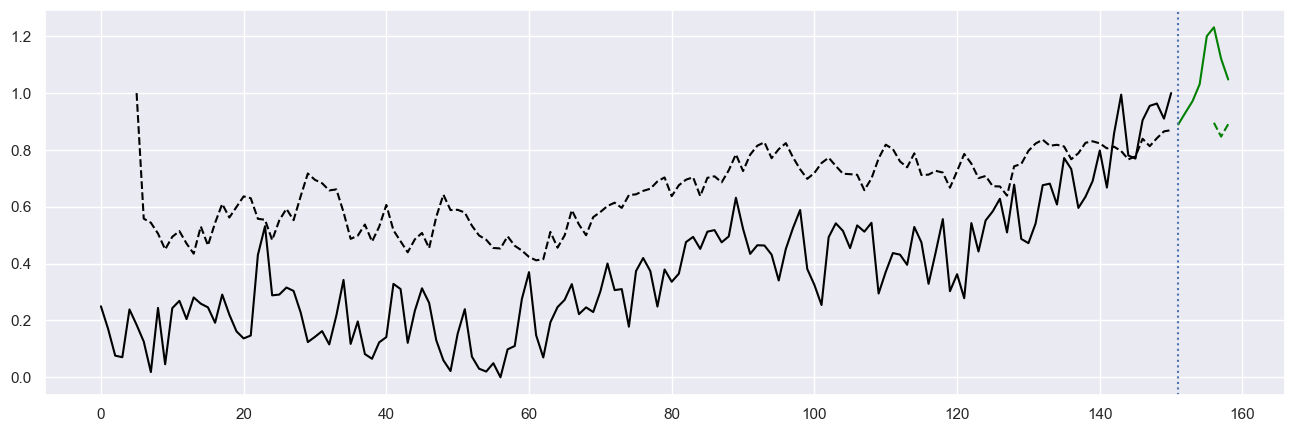

In [80]:
####### ZII, IZI, IIZ 
plt.figure(figsize=(16,5))

plt.plot(train_df[:,0], color='black', label='Train data')
plt.plot(length+np.arange(len(train_predictions)),train_predictions, color='black', label='Train Prediction',linestyle='dashed')

plt.plot(len(train_df)+np.arange(len(valid_df)),valid_df[:,0], color='green', label='Valid data')
plt.plot(length+len(train_df)+np.arange(len(valid_predictions)),valid_predictions, color='green', label='Valid Prediction',linestyle='dashed')

plt.plot(len(train_df)+len(valid_df)+np.arange(len(test_df_new)),test_df_new[:,0], color='blue', label='Test data')
plt.plot(length+len(train_df)+len(valid_df)+np.arange(len(predictions)),predictions, color='red', label='Predicted data',linestyle='dashed')

plt.axvline(len(train_df), linestyle=':')

## Classical LSTM 

In [81]:
class Model_LSTM(nn.Module):

    def __init__(self, 
                    input_dim,
                    hidden_dim, 
                    batch_size, 
                    target_size, 
                    
                 ):
        super(Model_LSTM, self).__init__()

        seed = 71
        np.random.seed = seed
        torch.manual_seed=seed
        
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        #self.dropout = nn.Dropout(0.2)
        # The linear layer that maps from hidden state space to target space
        self.dense = nn.Linear(hidden_dim, target_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        #out = self.dropout(out)
        dense_out = self.dense(out)
        out_scores=dense_out
        # out_scores = F.log_softmax(dense_out, dim=1)
        return out_scores

In [122]:
###############################
# Change manually this params
###############################
input_size = 3
hidden_dim = 4
n_epochs = 10
target_size = 1
batch_size= 1

print(f"Input dim:    {input_size}")
print(f"LSTM output size: {hidden_dim}")
print(f"Number of qubits: {n_qubits}")
print(f"Training epochs:  {n_epochs}")

model_lstm = Model_LSTM(input_size,
                hidden_dim,
                batch_size,
                target_size=target_size,
                )

def count_parameters(model_lstm):
    return sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)

print(f"Model Parameters:  {count_parameters(model_lstm)}")

loss_function = nn.MSELoss()
#optimizer = optim.RMSprop(model.parameters(), lr=0.01) #Original
# optimizer = optim.RMSprop(model_lstm.parameters(), lr=0.01,momentum=0.2)

optimizer = optim.RMSprop(model_lstm.parameters(), lr=0.001,momentum=0.2)

model_lstm.dense.requires_grad_(False)

history = {
    'train_loss': [],
    'valid_loss': [],
    'mae': [],
    'rmse': []
}
for epoch in range(n_epochs):
    train_losses = []
    preds = []
    targets = []
    model_lstm.train()
    
    for i,X in enumerate(tqdm(train_window)):

        if i ==len(train_window)-1:
            break;
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Step 3. Run our forward pass.
        X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
        try:
            out_scores = model_lstm(X_in)[-1]
        except Exception as e:
            print("There was a mistake in the code: ",e) 
            continue        # out_scores = model(X_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        # label= torch.Tensor([X[1]]).reshape((length,1))
        label= torch.Tensor([X[1]]).reshape((batch_size,1))
        loss = loss_function(out_scores,label)
        loss.backward()
        optimizer.step()
        train_losses.append(float(loss))

        # probs = torch.softmax(out_scores, dim=-1)
        # preds.append(probs.argmax(dim=-1))
        preds.append(torch.Tensor(out_scores.detach()))
        # targets.append(label[-1])
        targets.append(label)
        
    valid_losses = []
    model_lstm.eval()     
    for i,X in enumerate(tqdm(valid_window)):
        if i ==len(valid_window)-1:
            break;
        X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
        try:
            out_scores = model_lstm(X_in)[-1]
        except Exception as e:
            print("There was a mistake in the  code: ",e) 
            continue     
        label= torch.Tensor([X[1]]).reshape((batch_size,1))
        loss = loss_function(out_scores,label)
        valid_losses.append(float(loss))

    avg_loss_train = np.mean(train_losses)
    avg_loss_valid = np.mean(valid_losses)
    history['train_loss'].append(avg_loss_train)
    history['valid_loss'].append(avg_loss_valid)
    #print("preds", preds,targets)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    mean_abs_error = MeanAbsoluteError()
    mae=mean_abs_error(preds, targets)
    mean_sqrt_error = MeanSquaredError()
    rmse=mean_sqrt_error(preds, targets)
    history['mae'].append(mae)
    history['rmse'].append(rmse)

    print(f"Epoch {epoch + 1} / {n_epochs}: Loss = {avg_loss_train:.3f} Valid Loss: {avg_loss_valid:.3f} MAE = {mae:.4f} RMSE = {rmse:.4f}")


Input dim:    3
LSTM output size: 4
Number of qubits: 3
Training epochs:  10
Model Parameters:  149


 67%|██████▋   | 2/3 [00:00<00:00, 2487.72it/s]


Epoch 1 / 10: Loss = 0.032 Valid Loss: 0.456 MAE = 0.1414 RMSE = 0.0316


 67%|██████▋   | 2/3 [00:00<00:00, 2747.66it/s]


Epoch 2 / 10: Loss = 0.052 Valid Loss: 0.449 MAE = 0.1880 RMSE = 0.0516


 67%|██████▋   | 2/3 [00:00<00:00, 2272.72it/s]


Epoch 3 / 10: Loss = 0.043 Valid Loss: 0.484 MAE = 0.1725 RMSE = 0.0433


 67%|██████▋   | 2/3 [00:00<00:00, 2481.10it/s]


Epoch 4 / 10: Loss = 0.032 Valid Loss: 0.467 MAE = 0.1407 RMSE = 0.0319


 67%|██████▋   | 2/3 [00:00<00:00, 2264.74it/s]


Epoch 5 / 10: Loss = 0.022 Valid Loss: 0.443 MAE = 0.1146 RMSE = 0.0225


 67%|██████▋   | 2/3 [00:00<00:00, 1081.01it/s]


Epoch 6 / 10: Loss = 0.029 Valid Loss: 0.443 MAE = 0.1366 RMSE = 0.0293


 67%|██████▋   | 2/3 [00:00<00:00, 2372.34it/s]


Epoch 7 / 10: Loss = 0.026 Valid Loss: 0.446 MAE = 0.1253 RMSE = 0.0258


 67%|██████▋   | 2/3 [00:00<00:00, 2604.35it/s]


Epoch 8 / 10: Loss = 0.021 Valid Loss: 0.440 MAE = 0.1082 RMSE = 0.0206


 67%|██████▋   | 2/3 [00:00<00:00, 2481.84it/s]


Epoch 9 / 10: Loss = 0.024 Valid Loss: 0.440 MAE = 0.1207 RMSE = 0.0240


 67%|██████▋   | 2/3 [00:00<00:00, 2725.34it/s]

Epoch 10 / 10: Loss = 0.022 Valid Loss: 0.440 MAE = 0.1146 RMSE = 0.0222


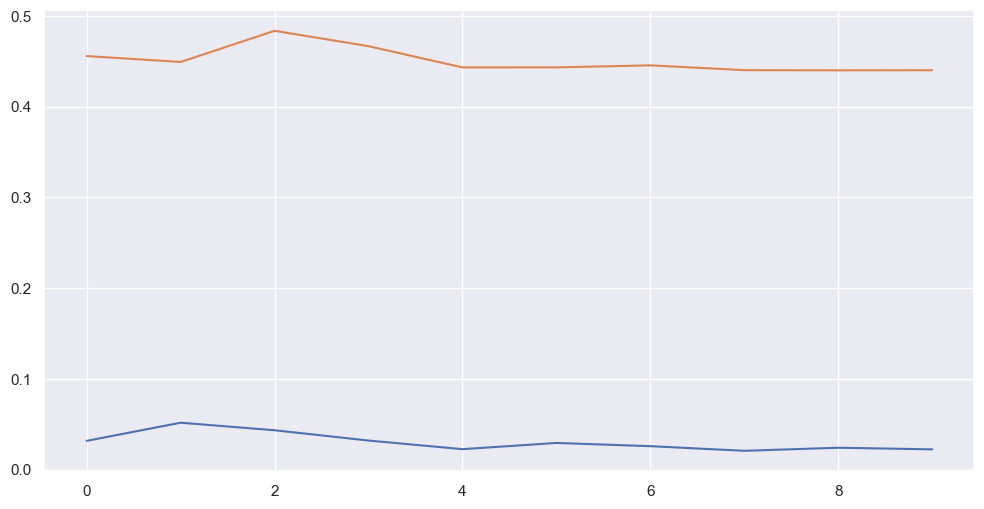

In [123]:
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])

In [124]:
lstm_train_predictions=np.array([])
model.eval()
for i,y in enumerate(train_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model_lstm(test_tensor)[-1]
        lstm_train_predictions=np.append(lstm_train_predictions,pred.detach().numpy())
    except: 
        pred=1
        lstm_train_predictions=np.append(lstm_train_predictions,pred)

lstm_valid_labels=np.array([])
lstm_valid_predictions=np.array([])
for i,y in enumerate(valid_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model_lstm(test_tensor)[-1]
        lstm_valid_predictions=np.append(lstm_valid_predictions,pred.detach().numpy())
        lstm_valid_labels= np.append(lstm_valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        lstm_valid_predictions=np.append(lstm_valid_predictions,pred)    
        lstm_valid_labels= np.append(lstm_valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
        
lstm_t_valid_predictions=torch.from_numpy(lstm_valid_predictions)
lstm_t_valid_labels=torch.from_numpy(lstm_valid_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(lstm_t_valid_predictions, lstm_t_valid_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(lstm_t_valid_predictions, lstm_t_valid_labels)
print("MAE Valid",mae)
print("MSE Valid",mse)

lstm_predictions=np.array([])
lstm_test_labels=np.array([])
for i,y in enumerate(test_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model_lstm(test_tensor)[-1]
        lstm_predictions=np.append(lstm_predictions,pred.detach().numpy())
        lstm_test_labels= np.append(lstm_test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        lstm_predictions=np.append(lstm_predictions,pred)
        lstm_test_labels= np.append(lstm_test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))

lstm_t_predictions=torch.from_numpy(lstm_predictions)
lstm_t_test_labels=torch.from_numpy(lstm_test_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(lstm_t_predictions, lstm_t_test_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(lstm_t_predictions, lstm_t_test_labels)
print("MAE Test",mae)
print("MSE Test",mse)    

MAE Valid tensor(0.6183)
MSE Valid tensor(0.3880)
MAE Test tensor(nan)
MSE Test tensor(nan)


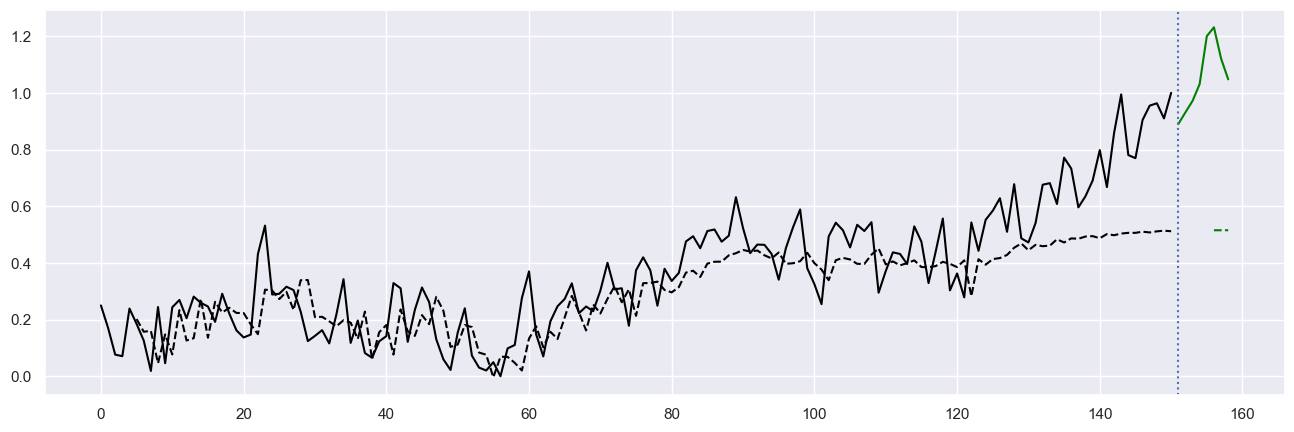

In [125]:
####### ZII, IZI, IIZ 
plt.figure(figsize=(16,5))

plt.plot(train_df[:,0], color='black', label='Train data')
plt.plot(length+np.arange(len(lstm_train_predictions)),lstm_train_predictions, color='black', label='Train Prediction',linestyle='dashed')

plt.plot(len(train_df)+np.arange(len(valid_df)),valid_df[:,0], color='green', label='Valid data')
plt.plot(length+len(train_df)+np.arange(len(lstm_valid_predictions)),lstm_valid_predictions, color='green', label='Valid Prediction',linestyle='dashed')

plt.plot(len(train_df)+len(valid_df)+np.arange(len(test_df_new)),test_df_new[:,0], color='blue', label='Test data')
plt.plot(length+len(train_df)+len(valid_df)+np.arange(len(lstm_predictions)),lstm_predictions, color='red', label='Predicted data',linestyle='dashed')

plt.axvline(len(train_df), linestyle=':')